# **Setup**

In [ ]:
#Imports
import os
import torch
import pandas as pd
from sklearn.model_selection import train_test_split
from torch import nn, optim
import torch.nn.functional as func
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# sys.path.append('/content/drive/MyDrive/499A')
# %cd '/content/drive/MyDrive/499A'
os.chdir('/content/drive/MyDrive/499A')
# EXPERIMENT_NAME 
EXPERIMENT_NAME = "Expt 21"

ROOT_DIR = os.path.abspath("./")
LOG_PATH = os.path.join(ROOT_DIR, "RNN logs", EXPERIMENT_NAME)

if not os.path.exists(os.path.join(ROOT_DIR, "RNN logs")):
    os.mkdir(os.path.join(ROOT_DIR, "RNN logs"))
    
if not os.path.exists(LOG_PATH):
    os.mkdir(LOG_PATH)

# **Load Data**

In [ ]:
!pwd

/content/drive/MyDrive/499A


In [ ]:
df = pd.read_csv('Dataset/BarisalFlood.csv')
df.head(5)

,Sl,Station_Names,Year,Month,Max_Temp,Min_Temp,Rainfall,Relative_Humidity,Wind_Speed,Cloud_Coverage,Bright_Sunshine,Station_Number,X_COR,Y_COR,LATITUDE,LONGITUDE,ALT,Period,Flood?
0,0,Barisal,1949,1,29.4,12.3,0,68,0.453704,0.6,7.831915,41950,536809.8,510151.9,22.7,90.36,4,1949.01,NaN
1,1,Barisal,1949,2,33.9,15.2,9,63,0.659259,0.9,8.314894,41950,536809.8,510151.9,22.7,90.36,4,1949.02,NaN
2,2,Barisal,1949,3,36.7,20.2,8,59,1.085185,1.5,8.131915,41950,536809.8,510151.9,22.7,90.36,4,1949.03,NaN
3,3,Barisal,1949,4,33.9,23.9,140,71,1.772222,3.9,8.219149,41950,536809.8,510151.9,22.7,90.36,4,1949.04,NaN
4,4,Barisal,1949,5,35.6,25.0,217,76,1.703704,4.1,7.046809,41950,536809.8,510151.9,22.7,90.36,4,1949.05,NaN


In [ ]:
df.shape

(780, 19)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 780 entries, 0 to 779
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Sl                 780 non-null    int64  
 1   Station_Names      780 non-null    object 
 2   Year               780 non-null    int64  
 3   Month              780 non-null    int64  
 4   Max_Temp           780 non-null    float64
 5   Min_Temp           780 non-null    float64
 6   Rainfall           780 non-null    int64  
 7   Relative_Humidity  780 non-null    int64  
 8   Wind_Speed         780 non-null    float64
 9   Cloud_Coverage     780 non-null    float64
 10  Bright_Sunshine    780 non-null    float64
 11  Station_Number     780 non-null    int64  
 12  X_COR              780 non-null    float64
 13  Y_COR              780 non-null    float64
 14  LATITUDE           780 non-null    float64
 15  LONGITUDE          780 non-null    float64
 16  ALT                780 non

In [ ]:
df['Flood?'].value_counts()

1.0    235
Name: Flood?, dtype: int64

In [ ]:
df['Flood?']=df['Flood?'].fillna(0)

In [ ]:
df['Flood?'].value_counts()

0.0    545
1.0    235
Name: Flood?, dtype: int64

In [ ]:
df['Flood?'].value_counts()/len(df)

0.0    0.698718
1.0    0.301282
Name: Flood?, dtype: float64

In [ ]:
X = df[['Year', 'Month', 'Max_Temp', 'Min_Temp', 'Rainfall', 'Relative_Humidity', 'Wind_Speed', 'Cloud_Coverage', 'Bright_Sunshine']]
y=df[['Flood?']]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [ ]:
X_train = torch.from_numpy(X_train.to_numpy()).float()
y_train = torch.squeeze(torch.from_numpy(y_train.to_numpy()).float())
X_test = torch.from_numpy(X_test.to_numpy()).float()
y_test = torch.squeeze(torch.from_numpy(y_test.to_numpy()).float())

In [ ]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

torch.Size([624, 9]) torch.Size([624])
torch.Size([156, 9]) torch.Size([156])


In [ ]:
#Creating the Model
class Model(nn.Module):
  def __init__(self, n_features):
    super(Model, self).__init__()
    self.fc1 = nn.Linear(n_features, 9)
    self.fc2 = nn.Linear(9, 7)
    self.fc3 = nn.Linear(7, 5)
    self.fc4 = nn.Linear(5, 3)
    self.fc5 = nn.Linear(3, 1)
  def forward(self, x):
    x = func.relu(self.fc1(x))
    x = func.relu(self.fc2(x))
    x = func.relu(self.fc3(x))
    x = func.relu(self.fc4(x))
    return torch.sigmoid(self.fc5(x))

In [ ]:
X_train.shape[1]

9

In [ ]:
model = Model(X_train.shape[1])

In [ ]:
criterion = nn.BCELoss()

In [ ]:
optimiser = optim.Adam(model.parameters(), lr = 0.001)

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
X_train = X_train.to(device)
y_train = y_train.to(device)

X_test = X_test.to(device)
y_test = y_test.to(device)

model = model.to(device)
criterion = criterion.to(device)

In [ ]:
def calculate_accuracy(y_true, y_pred):
  predicted = y_pred.ge(.5).view(-1)
  return (y_true == predicted).sum().float() / len(y_true)

In [ ]:
def round_tensor(t, decimal_places = 3):
  return round(t.item(), decimal_places)

In [ ]:
#Training Starts
for epoch in range(1000):
    y_pred = model(X_train)
    y_pred = torch.squeeze(y_pred)
    train_loss = criterion(y_pred, y_train)
    if epoch % 100 == 0:
      train_acc = calculate_accuracy(y_train, y_pred)
      y_test_pred = model(X_test)
      y_test_pred = torch.squeeze(y_test_pred)
      test_loss = criterion(y_test_pred, y_test)
      test_acc = calculate_accuracy(y_test, y_test_pred)
      print (str('epoch ') + str(epoch) + str(' Train set: loss: ') + str(round_tensor(train_loss)) + str(', accuracy: ') + str(round_tensor(train_acc)) + str(' Test  set: loss: ') + str(round_tensor(test_loss)) + str(', accuracy: ') + str(round_tensor(test_acc)))
    optimiser.zero_grad()
    train_loss.backward()
    optimiser.step()

epoch 0 Train set: loss: 6.344, accuracy: 0.293 Test  set: loss: 5.952, accuracy: 0.333
epoch 100 Train set: loss: 0.219, accuracy: 0.931 Test  set: loss: 0.244, accuracy: 0.904
epoch 200 Train set: loss: 0.158, accuracy: 0.942 Test  set: loss: 0.198, accuracy: 0.904
epoch 300 Train set: loss: 0.145, accuracy: 0.941 Test  set: loss: 0.195, accuracy: 0.904
epoch 400 Train set: loss: 0.14, accuracy: 0.941 Test  set: loss: 0.198, accuracy: 0.904
epoch 500 Train set: loss: 0.139, accuracy: 0.941 Test  set: loss: 0.201, accuracy: 0.904
epoch 600 Train set: loss: 0.138, accuracy: 0.941 Test  set: loss: 0.203, accuracy: 0.904
epoch 700 Train set: loss: 0.138, accuracy: 0.941 Test  set: loss: 0.204, accuracy: 0.904
epoch 800 Train set: loss: 0.137, accuracy: 0.941 Test  set: loss: 0.205, accuracy: 0.904
epoch 900 Train set: loss: 0.137, accuracy: 0.941 Test  set: loss: 0.205, accuracy: 0.904


In [ ]:
classes = ['No Flood', 'Flood']

y_pred = model(X_test)
y_pred = y_pred.ge(.5).view(-1).cpu()
y_test = y_test.cpu()
print(classification_report(y_test, y_pred, target_names=classes))

              precision    recall  f1-score   support

    No Flood       0.94      0.91      0.93       104
       Flood       0.84      0.88      0.86        52

    accuracy                           0.90       156
   macro avg       0.89      0.90      0.89       156
weighted avg       0.91      0.90      0.90       156



Text(0.5, 15.0, 'Predicted label')

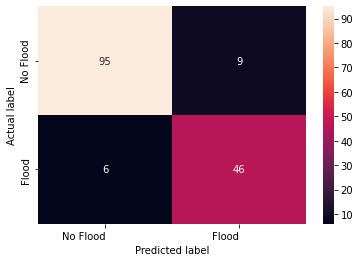

In [ ]:
conf_mat = confusion_matrix(y_test, y_pred)
df_conf_mat = pd.DataFrame(conf_mat, index = classes, columns = classes)
heat_map = sns.heatmap(df_conf_mat, annot = True, fmt = 'd')
heat_map.yaxis.set_ticklabels(heat_map.yaxis.get_ticklabels(), ha = 'right')
heat_map.xaxis.set_ticklabels(heat_map.xaxis.get_ticklabels(), ha = 'right')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')